# Librerías

In [1]:
#Manejo de datos
import pandas as pd
import numpy as np
import yfinance as yf

#Gráficos
import matplotlib.pyplot as plt

#Framework de optimización evolutiva
import random
from deap import base, creator, tools, algorithms

#Advertencias
import warnings
warnings.filterwarnings('ignore')

# Descarga de datos

In [2]:
activos = ['AAPL', 'TSLA', 'F', 'GE']
datos = pd.DataFrame()
for i in activos:
    datos[i] = yf.download(i, start = '2021-01-01', end = '2024-03-31')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


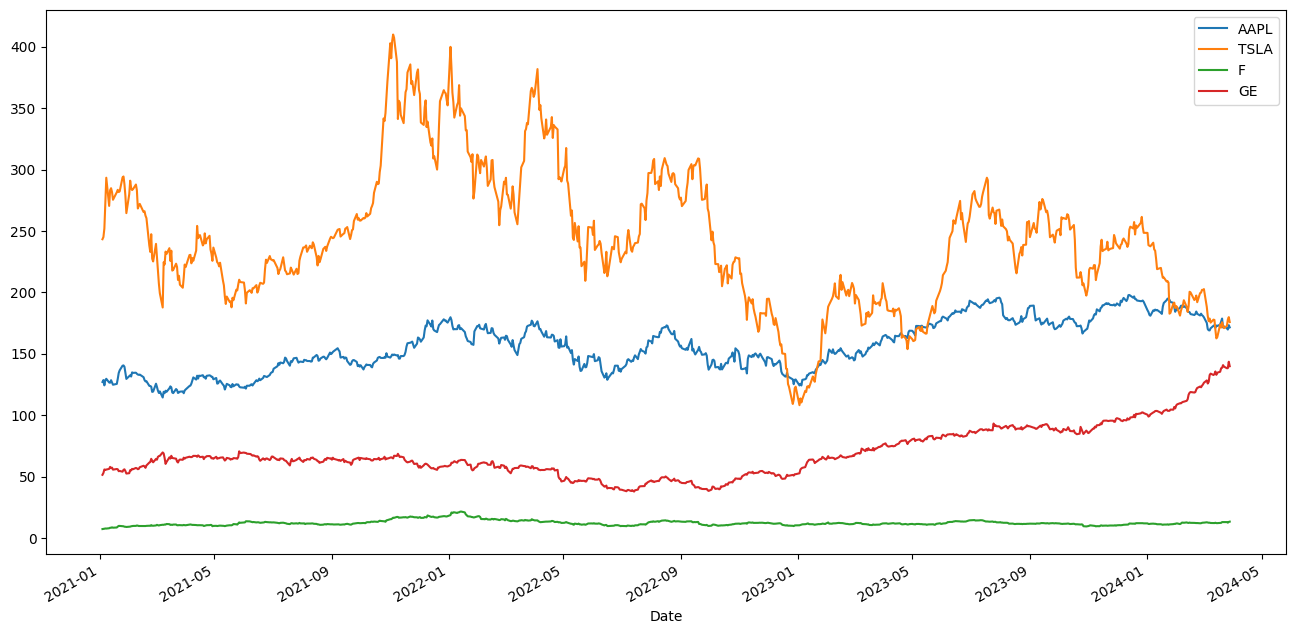

In [3]:
datos.plot(figsize = (16, 8))
plt.show()

In [4]:
retorno_simple = datos.pct_change().dropna()
retorno_logaritmico = np.log(datos/datos.shift(1)).dropna()

# Función de adaptabilidad

In [5]:
#Función de adaptabilidad
def evaluar_portafolio(individuo, ret_simple, ret_log):
    capacidad = 1000
    pesos = np.array(individuo) / np.sum(individuo)
    if np.sum(individuo) <= capacidad:
        rentabilidad = np.dot((ret_simple.mean() * 252), pesos)
        riesgo = np.sqrt(np.dot(np.transpose(pesos), np.dot((ret_log.cov() * 252), pesos)))
    else:
        rentabilidad = 0
        riesgo = 99999999
    return rentabilidad, riesgo,

In [6]:
#Declarar el contenedor de las operaciones genéticas
toolbox = base.Toolbox()
#Habilitar la función de adaptabilidad y el individuo
creator.create('FitnessMulti', base.Fitness, weights = (1.0, -1.0,))
creator.create('Individual', list, fitness = creator.FitnessMulti)
#Declarar la forma y tamaño del individuo
##Declarar el tipo de gen
toolbox.register('attribute', random.randint, 100, 450)
##Declarar el tamaño del individuo
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attribute, n = 4) 
#Declarar la población
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
#Confirmación de la creación del individuo y la población
ind = toolbox.individual()
print('Individuo: ', ind)
pop = toolbox.population(n = 6)
print('Población: ', pop)

Individuo:  [178, 140, 239, 334]
Población:  [[122, 150, 176, 294], [132, 225, 117, 156], [346, 401, 289, 408], [303, 272, 350, 193], [267, 138, 176, 401], [422, 164, 126, 406]]


In [7]:
#Confirmar la funcionalidad de la función de adaptabilidad
ind = toolbox.individual()
print('Individuo a evaluar')
print(ind)
print(ind.fitness.valid)
ind.fitness.values = evaluar_portafolio(ind, retorno_simple, retorno_logaritmico)
print('Individuo evaluado')
print(ind)
print(ind.fitness.valid)
print(ind.fitness)
print(ind/np.sum(ind))

Individuo a evaluar
[284, 442, 368, 317]
False
Individuo evaluado
[284, 442, 368, 317]
True
(0.0, 99999999.0)
[0.20127569 0.31325301 0.26080794 0.22466336]


In [8]:
#Selección
toolbox.register('select', tools.selTournament, tournsize = 3)
#Cruce
toolbox.register('mate', tools.cxOnePoint)
#Mutación
toolbox.register('mutate', tools.mutGaussian, mu = 200, sigma = 1, indpb = 0)
#Adaptabilidad
toolbox.register('evaluate', evaluar_portafolio, ret_simple = retorno_simple, ret_log = retorno_logaritmico)

In [9]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('Promedio', np.mean)
stats.register('Desviación', np.std)
stats.register('Máximo', np.max)
stats.register('Mínimo', np.min)

In [10]:
population = toolbox.population(n = 1000)
population, logbook = algorithms.eaSimple(population,
                                          toolbox,
                                          cxpb = 1,
                                          mutpb = 0,
                                          ngen = 100,
                                          stats = stats, verbose = True)

gen	nevals	Promedio 	Desviación 	Máximo	Mínimo
0  	1000  	3.275e+07	4.69301e+07	1e+08 	0     
1  	1000  	1.965e+07	3.97351e+07	1e+08 	0     
2  	1000  	7.35e+06 	2.60955e+07	1e+08 	0     
3  	1000  	3.25e+06 	1.77324e+07	1e+08 	0     
4  	1000  	1.3e+06  	1.13274e+07	1e+08 	0     
5  	1000  	1.1e+06  	1.04302e+07	1e+08 	0     
6  	1000  	600000   	7.72269e+06	1e+08 	0     
7  	1000  	600000   	7.72269e+06	1e+08 	0     
8  	1000  	600000   	7.72269e+06	1e+08 	0     
9  	1000  	200000   	4.46766e+06	1e+08 	0     
10 	1000  	0.27476  	0.00292454 	0.284948	0.267302
11 	1000  	0.275155 	0.00278982 	0.283147	0.268473
12 	1000  	0.275248 	0.00295518 	0.283147	0.268496
13 	1000  	0.274809 	0.00314466 	0.283147	0.268764
14 	1000  	0.273965 	0.00325366 	0.281248	0.269037
15 	1000  	0.273599 	0.0034067  	0.278997	0.269172
16 	1000  	0.273312 	0.00360462 	0.27691 	0.269172
17 	1000  	0.273106 	0.00380311 	0.27691 	0.269173
18 	1000  	0.273045 	0.00386489 	0.27691 	0.269173
19 	1000  	0.273041 	0.0

In [11]:
print('El resultado de la evolución es: ')
print(logbook)

El resultado de la evolución es: 
gen	nevals	Promedio 	Desviación 	Máximo  	Mínimo  
0  	1000  	3.275e+07	4.69301e+07	1e+08   	0       
1  	1000  	1.965e+07	3.97351e+07	1e+08   	0       
2  	1000  	7.35e+06 	2.60955e+07	1e+08   	0       
3  	1000  	3.25e+06 	1.77324e+07	1e+08   	0       
4  	1000  	1.3e+06  	1.13274e+07	1e+08   	0       
5  	1000  	1.1e+06  	1.04302e+07	1e+08   	0       
6  	1000  	600000   	7.72269e+06	1e+08   	0       
7  	1000  	600000   	7.72269e+06	1e+08   	0       
8  	1000  	600000   	7.72269e+06	1e+08   	0       
9  	1000  	200000   	4.46766e+06	1e+08   	0       
10 	1000  	0.27476  	0.00292454 	0.284948	0.267302
11 	1000  	0.275155 	0.00278982 	0.283147	0.268473
12 	1000  	0.275248 	0.00295518 	0.283147	0.268496
13 	1000  	0.274809 	0.00314466 	0.283147	0.268764
14 	1000  	0.273965 	0.00325366 	0.281248	0.269037
15 	1000  	0.273599 	0.0034067  	0.278997	0.269172
16 	1000  	0.273312 	0.00360462 	0.27691 	0.269172
17 	1000  	0.273106 	0.00380311 	0.27691 	0.2691

In [12]:
print('El individuo que maximiza la rentabilidad y minimza el riesgo es: ')
print(tools.selBest(population, 1)[0])

El individuo que maximiza la rentabilidad y minimza el riesgo es: 
[100, 100, 104, 449]
